# Data Cleaning and Alignment of Time Series

This notebook takes as its inputs the trimmed versions of the large MATLAB files that store the Waverider Mk3 buoy data from Rottnest and Cottesloe, and outputs these data in a format suitable for machine learning and statistical analysis tasks. To this end, the tasks performed in this notebook are:
- converting MATLAB date formats to standard Date Time format
- aligning the data on record dates
- exploration of time series consistency and further pruning
- time series rounding and alignment, and finally
- merging and outputing the Rottnest and Cottesloe data

To ensure ease of use, this notebook is also available as a python script (`data-transform-align.py`) that only contains the core components needed to transform these data, and can be run from the command line or incorporated as part of a data processing pipeline.

#### Environment/package dependencies:
- Python >= 3.6
- `pandas`
- `numpy`
___

# 0  Imports

In [34]:
import numpy as np
import pandas as pd
import datetime as dt
import plotly.express as px
import plotly.io as pio
from plot_template import theme
from os import path

pd.options.plotting.backend = 'plotly'
pio.renderers.default = 'png'
px.defaults.height = 650
px.defaults.width = 1000
px.defaults.template = 'plotly_dark'

In [47]:
def show(plot, h=650, w=1000):
    plot = theme(plot)
    plot.show(height=h, width=w)

# 1  Data read and cleaning

In [3]:
INPATH = './Data'  # location of .json files
OUTPATH = './Data'  # location to save output csv files

In [22]:
cott, rott = (pd.read_json(path.join(INPATH, f'{buoy}-waves.json')) for buoy in ['cott','rott'])

In [23]:
cott.head()

,Dp,Hs,Tm,Tp,time
0,255.93750,0.63,5.000000,14.285714,733856.979167
1,279.84375,0.68,4.081633,6.666667,733857.000000
2,270.00000,0.69,4.255319,10.000000,733857.020833
3,240.46875,0.71,4.301075,10.526316,733857.041667
4,255.93750,0.74,4.210526,10.526316,733857.062500


In [24]:
# Convert MATLAB time format to standard DateTime
def matlab2datetime(matlab_datenum):
    day = dt.datetime.fromordinal(int(matlab_datenum))
    dayfrac = dt.timedelta(days=matlab_datenum%1) - dt.timedelta(days=366)
    return day + dayfrac

In [25]:
# Round to nearest min to remove floating point errors
cott['DateTime'] = cott['time'].apply(matlab2datetime).apply(lambda x: x.round('T'))
rott['DateTime'] = rott['time'].apply(matlab2datetime).apply(lambda x: x.round('T'))

In [26]:
data_dict = {'Dp': 'Direction', 'Tp': 'PeakPeriod', 'Tm': 'MeanPeriod', 'Hs': 'Height'}
col_order = ['DateTime','Height','PeakPeriod','MeanPeriod','Direction']
cott = cott.rename(columns=data_dict)[col_order]
rott = rott.rename(columns=data_dict)[col_order]

In [27]:
cott.head()

,DateTime,Height,PeakPeriod,MeanPeriod,Direction
0,2009-03-24 23:30:00,0.63,14.285714,5.000000,255.93750
1,2009-03-25 00:00:00,0.68,6.666667,4.081633,279.84375
2,2009-03-25 00:30:00,0.69,10.000000,4.255319,270.00000
3,2009-03-25 01:00:00,0.71,10.526316,4.301075,240.46875
4,2009-03-25 01:30:00,0.74,10.526316,4.210526,255.93750


In [30]:
# Saving semi-cleaned CSV format data
cott.to_csv(path.join(OUTPATH, 'cott-waves.csv'), index=False)
rott.to_csv(path.join(OUTPATH, 'rott-waves.csv'), index=False)

___
# 2  Aligning dates

In [89]:
cott['Date'] = cott['DateTime'].dt.date
rott['Date'] = rott['DateTime'].dt.date

In [52]:
def plot_record_dates(cott, rott, title=''):
    dates = pd.DataFrame(dict(
        Location=(['Rottnest']*len(rott) + ['Cottesloe']*len(cott)),
        Date=rott['Date'].append(cott['Date'])))

    p = theme(px.histogram(dates, x='Date', color='Location', opacity=0.65,
                 barmode='overlay', title=title))
    return p

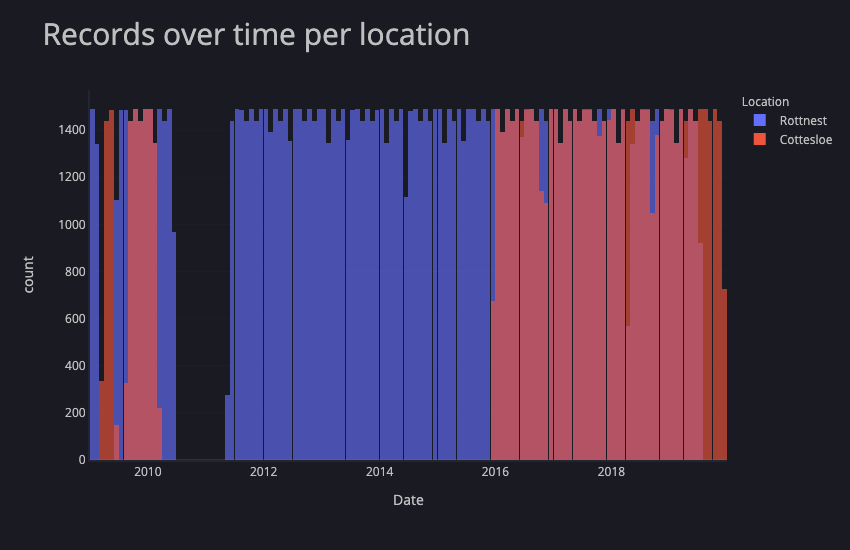

In [53]:
p = plot_record_dates(cott, rott, 'Records over time per location')
show(p, h=550, w=850)

### Filtering out dates that do not exist in both datasets

In [90]:
filt = rott['Date'].isin(cott['Date'])
rott_all = rott.copy()
rott = rott[filt].copy()

filt = cott['Date'].isin(rott['Date'])
cott_all = cott.copy()
cott = cott[filt].copy()

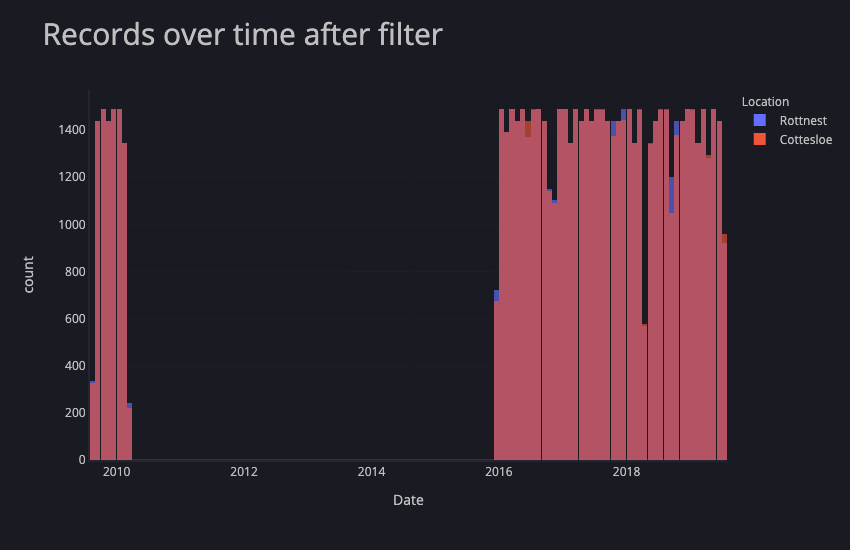

In [55]:
p = plot_record_dates(cott, rott, 'Records over time after filter')
show(p, h=550, w=850)

### Filtering records from before Cottesloe buoy shutdown in 2010

In [91]:
threshold = pd.Timestamp('2015-12-01')
cott = cott[cott['DateTime'] > threshold]
rott = rott[rott['DateTime'] > threshold]

___
# 3  Exploring consistency of time series
The client informed that the Waverider buoys consistently log records at 30 minute intervals, and the only time at which they won't is when either:
- They are being serviced, or
- There is a fault of some kind

The buoys will then again log records every 30 minutes from the moment they are switched back on, meaning that the exact minute of these records is arbritrary. As such, it was recommended that, rather than using a resampling technique such as *imputation* to match the timestamps, it would be more appropriate to simply *round* their timestamps to the nearest 30 minutes.

In [92]:
rott_filt1 = rott['DateTime'].diff().isin([pd.Timedelta(30, 'm'), pd.NaT])
print(f'The number of recordings not on a 30min interval in Rottnest is: {len(rott_filt1) - len(rott[rott_filt1])}')
rott = rott[rott_filt1]

The number of recordings not on a 30min interval in Rottnest is: 30


In [93]:
cott_filt1 = cott['DateTime'].diff().isin([pd.Timedelta(30, 'm'), pd.NaT])
print(f'The number of recordings not on a 30min interval in Cottesloe is: {len(cott) - len(cott[cott_filt1])}')
cott = cott[cott_filt1]

The number of recordings not on a 30min interval in Cottesloe is: 15


In [94]:
rott = rott.reset_index(drop=True)
cott = cott.reset_index(drop=True)

In [95]:
rott_filt2 = rott['DateTime'].diff().isin([pd.Timedelta(30, 'm'), pd.NaT])
rott_buoy_service = list(rott[~rott_filt2].index)
print(f'The number of 30min groups in Rottnest is: {len(rott_buoy_service)}')

The number of 30min groups in Rottnest is: 20


In [97]:
cott_filt2 = cott['DateTime'].diff().isin([pd.Timedelta(30, 'm'), pd.NaT])
cott_buoy_service = list(cott[~cott_filt2].index)
print(f'The number of 30min groups in Cottesloe is: {len(cott_buoy_service)}')

The number of 30min groups in Cottesloe is: 12


## Groupings of 30 minute recordings for each buoy

<img src="img/align-group-vis.png" style="max-width: 900px">

___
# 4  Aligning time series
Performing the time series '*rounding*' to complete the alignment of the Rottnest and Cottesloe data.

In [99]:
def round_to_30(tm):
    if tm.minute == 15:
        tm += pd.Timedelta('15min')  # making 15 -> 30 instead of 00
    else:
        tm = tm.round('30min')
    return tm

In [100]:
rott.drop(columns='Date', inplace=True)
cott.drop(columns='Date', inplace=True)

In [101]:
rott['DateTimeRounded'] = rott['DateTime'].apply(round_to_30)
cott['DateTimeRounded'] = cott['DateTime'].apply(round_to_30)

In [103]:
filt_rott_dts = rott['DateTimeRounded'].isin(cott['DateTimeRounded'])
print(f'Percentage of exact rounded Rottnest datetimes also in Cottesloe: {round(filt_rott_dts.sum() / len(rott) * 100, 2)}%')

Percentage of exact rounded Rottnest datetimes also in Cottosloe: 99.35%


In [104]:
filt_cott_dts = cott['DateTimeRounded'].isin(rott['DateTimeRounded'])
print(f'Percentage of exact rounded Cottesloe datetimes also in Rottnest: {round(filt_cott_dts.sum() / len(cott) * 100, 2)}%')

Percentage of exact rounded Cottesloe datetimes also in Rottnest: 99.74%


In [105]:
rott_filtered = rott[filt_rott_dts].reset_index(drop=True)
cott_filtered = cott[filt_cott_dts].reset_index(drop=True)

##### Checking the filtering worked:

In [108]:
all(cott_filtered['DateTimeRounded'].isin(rott['DateTimeRounded']))

True

In [109]:
all(rott_filtered['DateTimeRounded'].isin(cott['DateTimeRounded']))

True

## 30 minute groupings of each buoy after aligning date times

<img src="img/aligned-group-vis.png" style="max-width: 900px">

In [110]:
cott_filtered.rename(columns={'DateTimeRounded': 'DateTime', 'DateTime': 'DateTimeOrig'}, inplace=True)
rott_filtered.rename(columns={'DateTimeRounded': 'DateTime', 'DateTime': 'DateTimeOrig'}, inplace=True)

In [116]:
col_order = ['DateTime','Height','PeakPeriod','MeanPeriod','Direction','DateTimeOrig']
cott_out = cott_filtered.loc[:,col_order]
rott_out = rott_filtered.loc[:,col_order]

In [117]:
# Taking record of amount of time shift (in minutes)
rott_out['TimeShift'] = (rott_out['DateTime'] - rott_out['DateTimeOrig']) / np.timedelta64(1,'m')
cott_out['TimeShift'] = (cott_out['DateTime'] - cott_out['DateTimeOrig']) / np.timedelta64(1,'m')

___
# 5  Merging the Cottesloe and Rottnest datasets

In [118]:
cott_to_merge = cott_out.rename(columns={col: f'Cott{col}' for col in cott_out})
rott_to_merge = rott_out.rename(columns={col: f'Rott{col}' for col in rott_out})

In [125]:
df = pd.merge(cott_to_merge, rott_to_merge, left_index=True, right_index=True)

In [126]:
df['TimeShiftTotal'] = abs(df['CottTimeShift'] - df['RottTimeShift'])
df = df.rename(columns={'CottDateTime': 'DateTime'}).drop(columns=['RottDateTime'])

In [127]:
df.head()

,DateTime,CottHeight,CottPeakPeriod,CottMeanPeriod,CottDirection,CottDateTimeOrig,CottTimeShift,RottHeight,RottPeakPeriod,RottMeanPeriod,RottDirection,RottDateTimeOrig,RottTimeShift,TimeShiftTotal
0,2015-12-17 22:30:00,0.69,13.333333,6.666667,268.59375,2015-12-17 22:30:00,0.0,2.17,13.333333,7.843137,250.3125,2015-12-17 22:15:00,15.0,15.0
1,2015-12-17 23:00:00,0.70,14.285714,6.349206,285.46875,2015-12-17 23:00:00,0.0,1.96,11.764706,7.547170,247.5000,2015-12-17 22:45:00,15.0,15.0
2,2015-12-17 23:30:00,0.72,12.500000,6.349206,254.53125,2015-12-17 23:30:00,0.0,2.27,13.333333,8.333333,247.5000,2015-12-17 23:15:00,15.0,15.0
3,2015-12-18 00:00:00,0.74,12.500000,6.349206,246.09375,2015-12-18 00:00:00,0.0,2.09,11.764706,8.000000,241.8750,2015-12-17 23:45:00,15.0,15.0
4,2015-12-18 00:30:00,0.74,14.285714,6.060606,255.93750,2015-12-18 00:30:00,0.0,2.11,13.333333,8.333333,247.5000,2015-12-18 00:15:00,15.0,15.0


In [129]:
dt_range = pd.date_range(min(df['DateTime']), max(df['DateTime']), freq='30min')
time_df = df.set_index('DateTime').reindex(index=dt_range)

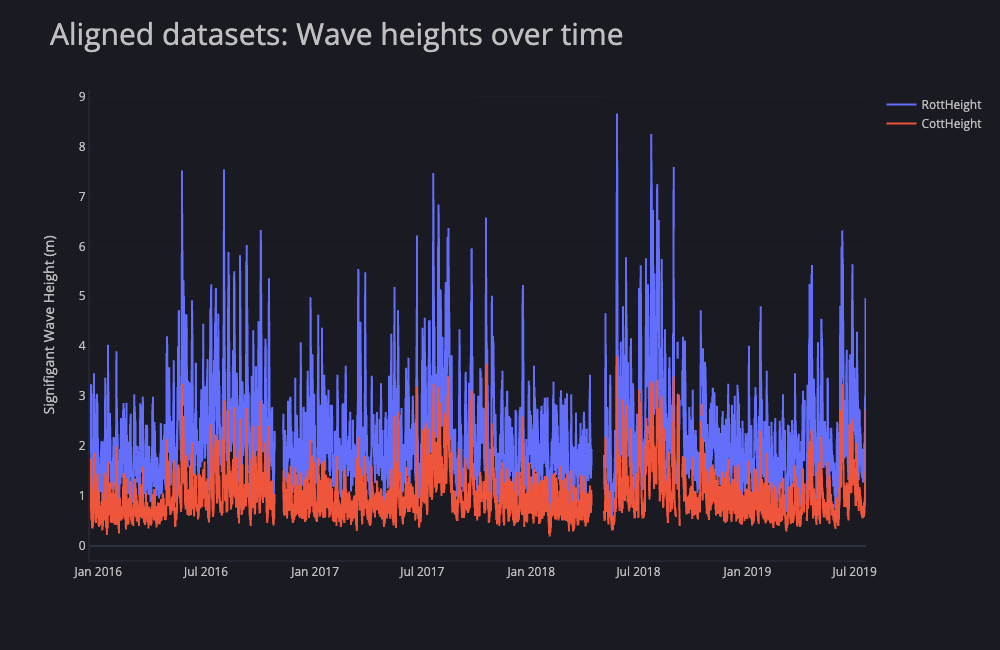

In [143]:
p = px.line(time_df, y=['RottHeight','CottHeight'],
            labels={'variable': '', 'index': '', 'value': 'Signifigant Wave Height (m)'},
            title='Aligned datasets: Wave heights over time')
show(p)

### Save merged dataset

In [137]:
df.to_csv(path.join(OUTPATH, 'ocean-waves.csv'), index=False)